In [1]:
import numpy as np
#import cv2
framerate = 29.18
from scipy import signal
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
#%cd "D:\Interfacial Waves resonance videos 0430"

## Frozen frequencies

In [67]:

frozenFreqs = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/frequencies.txt')
noRampVids = ['06V', '07V', '075V', '08V', '085V', '09V', '1V' , '11V', '12V', '125V', '13V', '135V', '14V', '145V', '15V']

Resonance = []
for v in noRampVids:
    plt.clf()
    ampl = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/movingAvg/%s.txt' %v)
    width = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/movingAvg/%sWidth.txt' %v)
    Resonance.append([np.max(ampl), np.max(width)])
Resonance = np.array(Resonance)
frozenFreqs = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/measured/frequencies.txt')
noRampVids = ['06V', '07V', '075V', '08V', '085V', '09V', '1V' , '11V', '12V', '125V', '13V', '135V', '14V', '145V', '15V']

surfaceResonance = []
for v in noRampVids:
    plt.clf()
    n = 10
    ampl = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0419/timeseries/surfaceresponse/%s' %v, skiprows=2)
    amplM = np.convolve(ampl[:,1], np.ones((n,))/n, mode='same')
    surfaceResonance.append([np.max(amplM)])
surfaceResonance = np.array(surfaceResonance)


<Figure size 432x288 with 0 Axes>

In [10]:
def read_file(src):
    img = cv2.flip(cv2.imread(src, cv2.IMREAD_GRAYSCALE), -1)
    return img

def printMaxAmpl(img, ref, col, loc):
    #img = img[120:515, loc[0]:loc[1]]
    #ref = ref[180:550, 600:700]
    #cv2.equalizeHist(img)
    #return locateInterface(img, maxplace, col)
    
    img = img[100:550, loc[0]:loc[1]]
    #ref = ref[180:550, 600:700]
    cv2.equalizeHist(img)

    cv2.equalizeHist(ref)
    imgref = img[:,col]
    refref = ref[:,col]
    peaksimg, _ = find_peaks(normalize(255.-imgref), height=1.25)
    peaks, _ = find_peaks(normalize(255.-refref), height=0.9)

    shorter =  np.min([len(peaksimg), len(peaks)])
    peaksimgcut = peaksimg
    peakscut = peaks[:shorter]
    maxplace = np.argmax(np.abs(np.diff(np.diff(peaksimgcut))))
    place = peaksimg[1:][maxplace]
    width = np.max(np.abs(np.diff(np.diff(peaksimgcut))))
    return [place, width]


def filterOnce(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)

    divs = np.abs(original-avg)> 2.5*std
    index = np.arange(0, len(original), 1)
    filtered[index[divs]] = filtered[index[divs]-1]
    #print(np.sum(divs))
    return filtered

def filterUntilSmooth(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)
    div = np.abs(original-avg) > 2.5*std
    while(np.sum(div)>0):
        filtered = filterOnce(filtered)
        avg = np.average(filtered)
        std = np.std(filtered)
        div = np.abs(filtered-avg)>2.5*std
    return filtered

def normalize(timeseries):
    avg = np.average(timeseries)
    stdev = np.std(np.abs(timeseries))
    return (timeseries-avg)/stdev

In [4]:
mediumRamp = np.loadtxt('data0430/MediumRamp.dat')
reverseRamp = np.loadtxt('data0430/reverseRamp.dat')
quickRamp = np.loadtxt('data0430/quickRamp.dat')
slowRamp = np.loadtxt('data0430/slowRamp.dat')


- mediumramp: in sync
- reverse ramp: in sync
- slow ramp: driving +2 sec


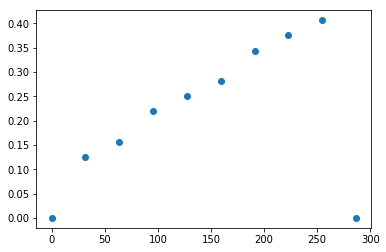

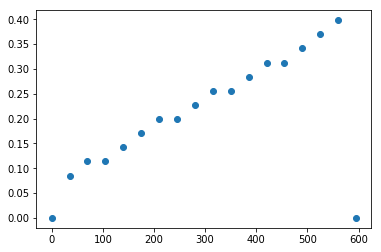

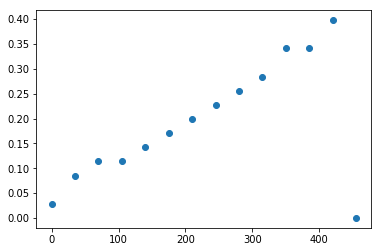

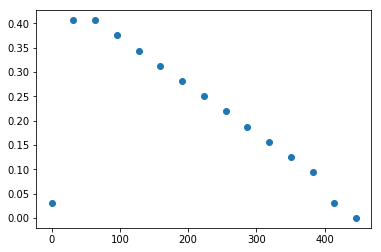

In [63]:
ramps = ['quickRamp', 'slowRamp','mediumRamp', 'reverseRamp']
data = [quickRamp, slowRamp, mediumRamp, reverseRamp]
allData = {}
from scipy.optimize import curve_fit
def lin(x, a,b):
    return x*a+b

for i,e in enumerate(ramps):
    dictionary = {}
    driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/driving/%s' %e, skiprows=2)
    surface = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0430/surfaceresponse/%s' %e, skiprows=2)
    dictionary['surface'] = surface
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal

    f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=200,noverlap=1, detrend='constant')
    dictionary['f'] = f
    dictionary['t'] = t

    dictionary['Zxx'] = Zxx
    dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    popt, pcov = curve_fit(lin, t, dictionary['frequencies'])
    plt.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
    plt.show()
    dictionary['coeffs'] = popt
    dictionary['errors'] = np.sqrt(np.diag(pcov))
    N = int(20*framerate)
    movingAvgI = np.convolve(data[i][:,0], np.ones((N,))/N, mode='same')
    movingAvgw = np.convolve(data[i][:,1], np.ones((N,))/N, mode='same')
    dictionary['movingAvg'] = movingAvgI
    dictionary['movingAvgw'] = movingAvgw
    dictionary['time'] = np.arange(0., data[i].shape[0],1)/framerate
    allData[e] = dictionary
    
    
    

In [60]:
from scipy import interpolate


In [61]:
def plotSpectrum(e):
    plt.clf()
    f, axes = plt.subplots(4, 2)
    plottime = allData[e]['time'][N:-N]
    surff = interpolate.interp1d(allData[e]['surface'][:,0], allData[e]['surface'][:,1])
    mmin = allData[e]['coeffs'][0] - allData[e]['errors'][0]
    mmax = allData[e]['coeffs'][0] + allData[e]['errors'][0]
    m = allData[e]['coeffs'][0]
    incpt = allData[e]['coeffs'][1]
    axes[0][0].plot(allData[e]['surface'][:,0], normalize(allData[e]['surface'][:,1]), '-o', markersize=1, c='black')
    axes[0][0].set_xlabel('Time')
    axes[0][0].set_ylabel('Water Surface position [px]')
    axes[0][0].set_title('Surface response')
    
    axes[1][0].plot(plottime, normalize(allData[e]['movingAvg'][N:-N]),'-o', markersize=1, c='black')
    axes[1][0].set_xlabel('Time')
    axes[1][0].set_ylabel('Interface Position [px]')
    axes[1][0].set_title('Interface response')
    
    axes[0][1].plot(lin(allData[e]['surface'][:,0], m, incpt),  normalize(allData[e]['surface'][:,1]), 'o', markersize=1, c='black')
    axes[0][1].plot(lin(allData[e]['surface'][:,0], mmax, incpt),  normalize(allData[e]['surface'][:,1]), 'o', markersize=1, c='blue')

    #axes[0][1].plot(frequencies, normalize(surfaceRes[:,1]), 'o', markersize=5, c='Crimson')
    axes[0][1].set_ylabel('Surface position')
    axes[0][1].set_xlabel('Driving frequency [Hz]')
    axes[0][1].plot(frozenFreqs, normalize(surfaceResonance), 'o', markersize=5, c='Crimson')
    axes[0][1].set_ylim(axes[0][0].get_ylim())
    axes[0][1].set_title('Driving: f(t)=%s t+%s' %(round(allData[e]['coeffs'][0], 5),  round(allData[e]['coeffs'][1], 3)))

    #axes[0][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[0][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')
    #axes[0][1].legend(loc='upper left')

    axes[1][1].plot(lin(plottime, m, incpt),  normalize(allData[e]['movingAvg'][N:-N]), 'o', markersize=1, c='black')
    axes[1][1].plot(lin(plottime, mmax, incpt),  normalize(allData[e]['movingAvg'][N:-N]), 'o', markersize=1, c='blue')

    axes[1][1].plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=5, c='Crimson')
    axes[1][1].set_ylim(axes[1][0].get_ylim())
    #axes[1][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[1][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')

    axes[1][1].set_ylabel('Interface position')
    axes[1][1].set_xlabel('Driving frequency [Hz]')


    axes[2][0].plot(plottime, normalize(allData[e]['movingAvgw'][N:-N]),'-o', markersize=1, c='black')
    axes[2][0].set_ylabel('Interface Width')
    axes[2][0].set_xlabel('Time')

    axes[2][1].plot(lin(plottime, mmin, incpt),  normalize(allData[e]['movingAvgw'][N:-N]), 'o', markersize=1, c='black')

    axes[2][1].plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Crimson')

    axes[2][1].set_ylim(axes[2][0].get_ylim())
    #axes[2][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[2][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')


    axes[2][1].set_ylabel('Interface width')
    axes[2][1].set_xlabel('Driving frequency [Hz]')


    axes[3][0].plot(plottime, normalize(allData[e]['movingAvg'][N:-N])-normalize(surff(plottime)),'-o', markersize=1, c='black')
    axes[3][0].set_ylabel('Interface-surface')
    axes[3][0].set_xlabel('Time')

    axes[3][1].plot(lin(plottime, m, incpt),  normalize(allData[e]['movingAvg'][N:-N])-normalize(surff(plottime)), 'o', markersize=1, c='black')

    axes[3][1].plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Crimson')

    axes[3][1].set_ylim(axes[2][0].get_ylim())
    #axes[2][1].plot([TheorResonance, TheorResonance],[-2., 4.], '-', linewidth = 2., c='Crimson', label = r'$f_{res}$')
    #axes[2][1].plot([2*TheorResonance, 2*TheorResonance],[-2., 4.], '-', linewidth = 2., c='Orange', label = r'$2f_{res}$')


    axes[3][1].set_ylabel('Interface-surface')
    axes[3][1].set_xlabel('Driving frequency [Hz]')


    
    f.set_size_inches((13, 8))
    f.tight_layout()
    #plt.savefig('%s.pdf' %e)
    plt.show()

In [54]:
def plotCorrelation(e):
    plt.clf()
    f, axes = plt.subplots(1, 3)
    plottime = allData[e]['time'][N:-N]
    surff = interpolate.interp1d(allData[e]['surface'][:,0], allData[e]['surface'][:,1])
    mmin = allData[e]['coeffs'][0] - allData[e]['errors'][0]
    mmax = allData[e]['coeffs'][0] + allData[e]['errors'][0]
    m = allData[e]['coeffs'][0]
    incpt = allData[e]['coeffs'][1]
    axes[0].plot(normalize(allData[e]['movingAvg'][N:-N]), normalize(surff(plottime)), 'o', markersize=1, c='black')
    axes[0].set_ylabel('Interface Position ')
    axes[0].set_xlabel('Water Surface position ')
    
    axes[1].plot( normalize(allData[e]['movingAvgw'][N:-N]), normalize(surff(plottime)),'o', markersize=1, c='black')
    axes[1].set_ylabel('Interface Width ')
    axes[1].set_xlabel('Water Surface position ')

    axes[2].plot(normalize(allData[e]['movingAvg'][N:-N]), normalize(allData[e]['movingAvgw'][N:-N]),'o', markersize=1, c='black')
    axes[2].set_ylabel('Interface Width')
    axes[2].set_xlabel('Interface Position')
    axes[2].set_title('Driving: f(t)=%s t+%s' %(round(allData[e]['coeffs'][0], 5),  round(allData[e]['coeffs'][1], 3)))
    for a in axes:
        a.set_xlim(-6., 6.)
        a.set_ylim(-6., 6.)
    f.set_size_inches((13, 8))
    f.tight_layout()
    #plt.savefig('%s.pdf' %e)
    plt.show()

In [55]:
allData['quickRamp']['errors']

array([0.0003725 , 0.05738165])

<Figure size 432x288 with 0 Axes>

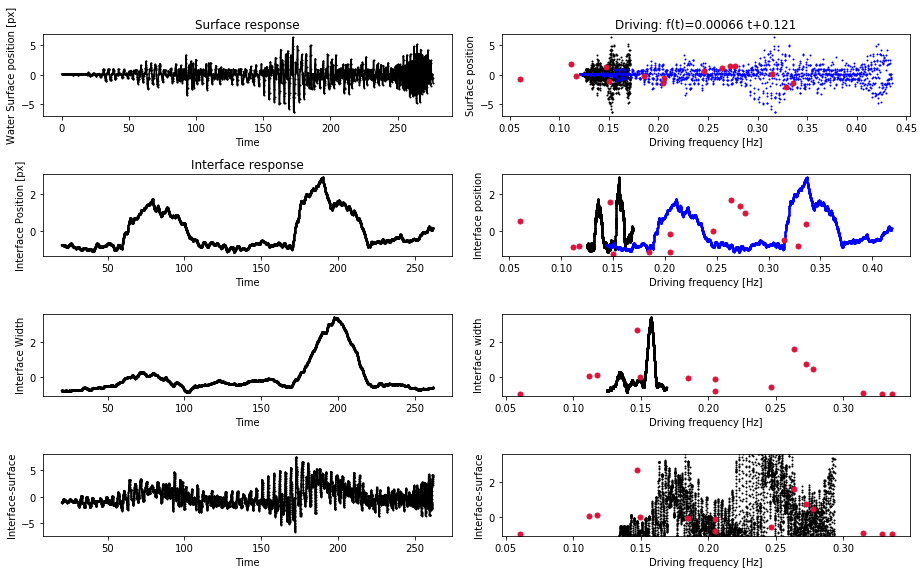

<Figure size 432x288 with 0 Axes>

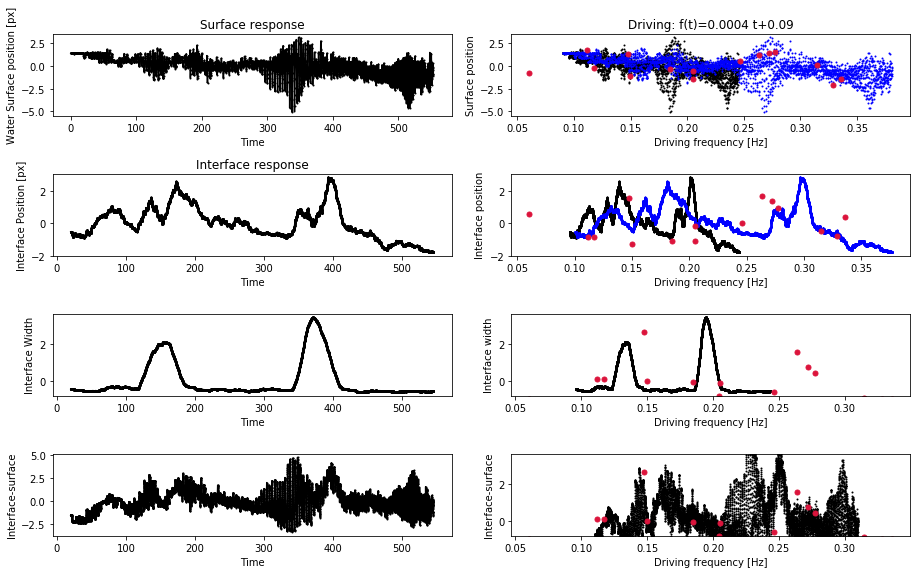

<Figure size 432x288 with 0 Axes>

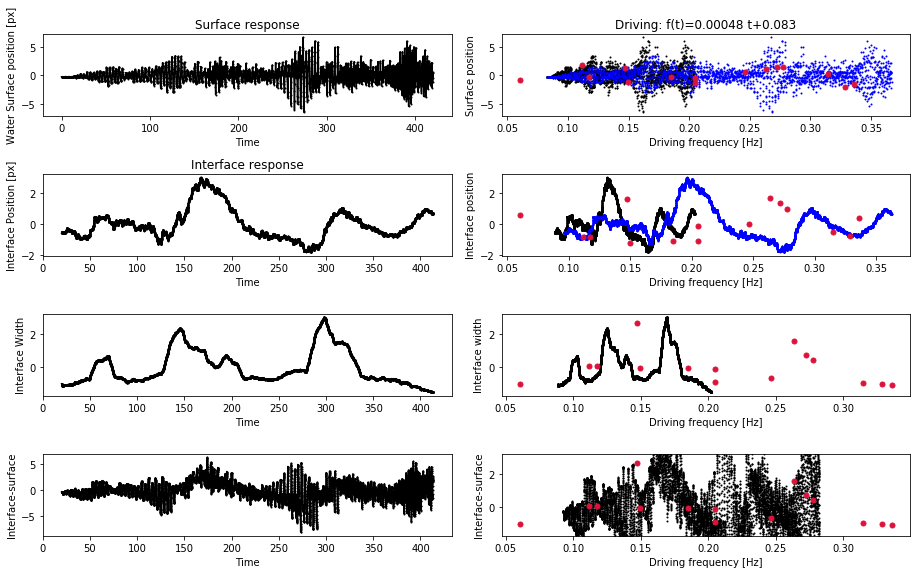

<Figure size 432x288 with 0 Axes>

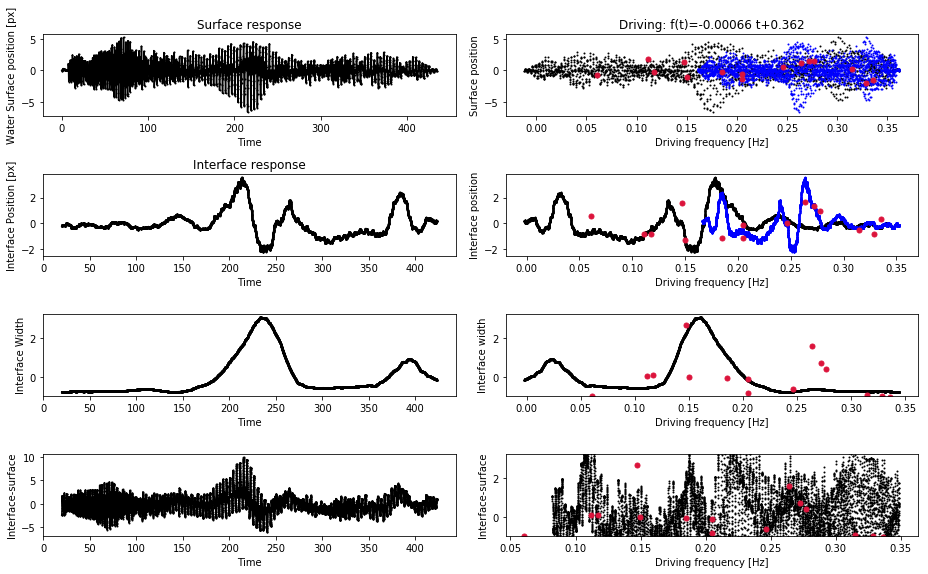

In [62]:
for e in ramps:
    plotSpectrum(e)

<Figure size 432x288 with 0 Axes>

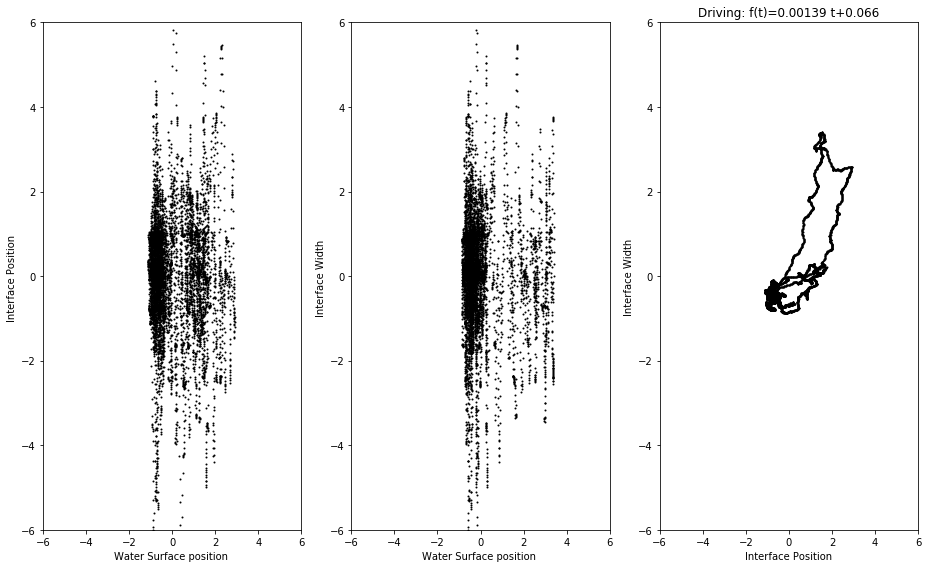

<Figure size 432x288 with 0 Axes>

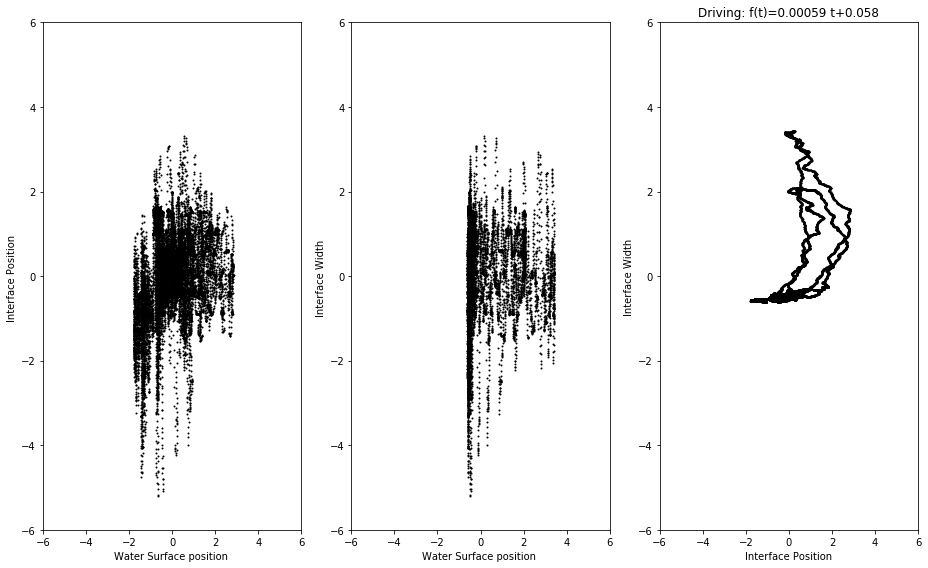

<Figure size 432x288 with 0 Axes>

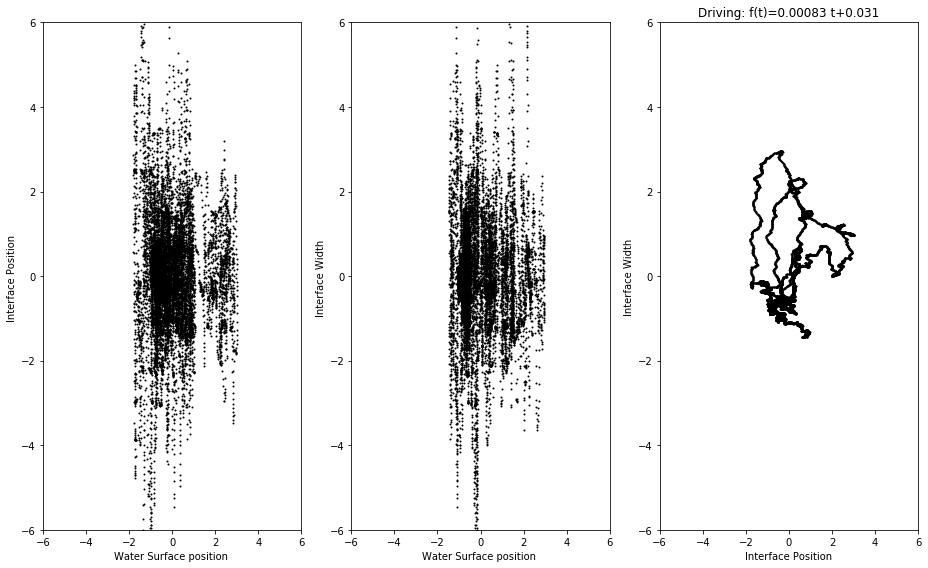

<Figure size 432x288 with 0 Axes>

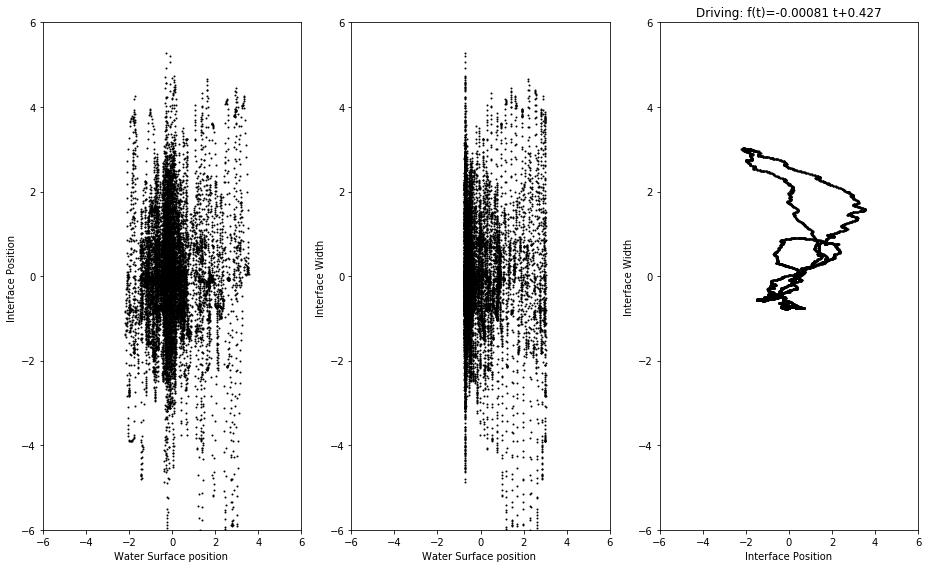

In [33]:
for e in ramps:
    plotCorrelation(e)

## Maximal interface width

In [112]:
def getMax(e):
    maxPlace = np.argmax(allData[e]['movingAvgw'])
    maxValue = np.max(normalize(allData[e]['movingAvgw']))
    maxFreq = lin(allData[e]['time'][maxPlace], *allData[e]['coeffs'])
    return [maxFreq, maxValue, allData[e]['coeffs'][0]]

def getMaxPosition(e):
    maxPlace = np.argmax(allData[e]['movingAvg'])
    maxValue = np.max(normalize(allData[e]['movingAvg']))
    maxFreq = lin(allData[e]['time'][maxPlace], *allData[e]['coeffs'])
    return [maxFreq, maxValue, allData[e]['coeffs'][0]]

In [114]:
maxWidthPlaces = []
maxAmplPlaces = []
for e in ramps:
    maxWidthPlaces.append(getMax(e))
    maxAmplPlaces.append(getMaxPosition(e))

In [115]:
maxWidthPlaces = np.array(maxWidthPlaces)
maxAmplPlaces = np.array(maxAmplPlaces)

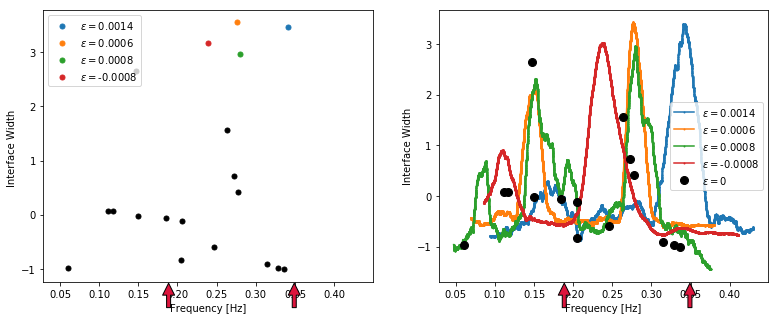

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=5, c='Black')
for e in maxWidthPlaces:
    
    ax1.plot(e[0], e[1], 'o', markersize=5, label='$\epsilon = $%s' %round(e[2], 4))
ax1.legend(loc='upper left')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Interface Width ')
for i,e in enumerate(ramps):
    plottime = allData[e]['time'][N:-N]    
    ax2.plot(lin(plottime, *allData[e]['coeffs']), normalize(allData[e]['movingAvgw'][N:-N]), '-o', markersize=1, label='$\epsilon = $%s' %round(maxWidthPlaces[i][2], 4))

ax2.plot(frozenFreqs, normalize(Resonance[:,1]), 'o', markersize=8, c='Black', label = '$\epsilon = 0$')

ax2.legend(loc='best')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Interface Width')
ax1.set_xlim(ax2.get_xlim())

markXaxis(ax1, TheorResonanceFirst)
markXaxis(ax2, TheorResonanceFirst)
#markXaxis(ax1, TheorResonanceSecond)
#markXaxis(ax2, TheorResonanceSecond)

markXaxis(ax1, 2*TheorResonanceFirst)
markXaxis(ax2, 2*TheorResonanceFirst)
#markXaxis(ax1, 2*TheorResonanceSecond)
#markXaxis(ax2, 2*TheorResonanceSecond)


In [11]:
0.26/ (2*TheorResonanceFirst)

0.8100242165448206

### Maximal amplitue

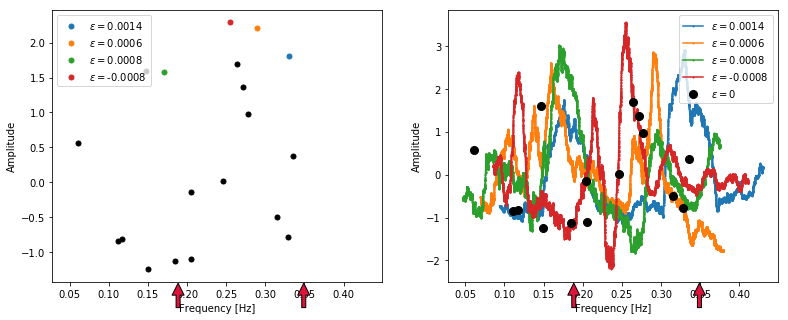

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=5, c='Black')
for e in maxAmplPlaces:

    ax1.plot(e[0], e[1], 'o', markersize=5, label='$\epsilon = $%s' %round(e[2], 4))
ax1.legend(loc='upper left')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
for i,e in enumerate(ramps):
    plottime = allData[e]['time'][N:-N]    
    ax2.plot(lin(plottime, *allData[e]['coeffs']), normalize(allData[e]['movingAvg'][N:-N]), '-o', markersize=1, label='$\epsilon = $%s' %round(maxAmplPlaces[i][2], 4))

ax2.plot(frozenFreqs, normalize(Resonance[:,0]), 'o', markersize=8, c='Black', label = '$\epsilon = 0$')

ax2.legend(loc='best')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude')
ax1.set_xlim(ax2.get_xlim())

markXaxis(ax1, TheorResonanceFirst)
markXaxis(ax2, TheorResonanceFirst)
#markXaxis(ax1, TheorResonanceSecond)
#markXaxis(ax2, TheorResonanceSecond)

markXaxis(ax1, 2*TheorResonanceFirst)
markXaxis(ax2, 2*TheorResonanceFirst)
#markXaxis(ax1, 2*TheorResonanceSecond)
#markXaxis(ax2, 2*TheorResonanceSecond)

### Resonance frequency as a function of the rate

Text(0, 0.5, 'Resonance frequency')

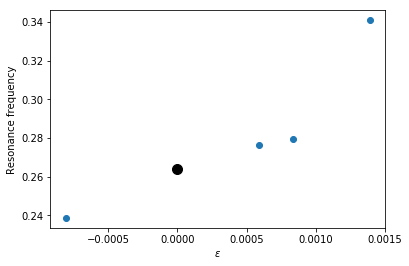

In [63]:
plt.plot(maxWidthPlaces[:,2], maxWidthPlaces[:,0], 'o')
plt.plot(0, frozenFreqs[-6], 'o', c='Black', markersize=10)
plt.xlabel('$\epsilon$')
plt.ylabel('Resonance frequency')

### Density profiles: 

#### 04.30

In [65]:
d = [51.7, 51.7, 51.6, 51.1, 50.4, 49.1, 48.8, 45.0, 33.4, 25.3, 9.14, 1.2, 0.9, 0.6, 0.5, 0.5, 0.5]
def cond_dens(x):
    return x**4*0.0000000000922584+x**3*(-0.0000000294733)+x**2*0.00000419348+x*0.000322098+0.999075
den = np.array(d)

## 05.02

05.02:  [1.02216006 1.02030918 1.01865104 1.01199298 1.00518742 1.00229267
 1.00229267 1.00007825]
04.30:  [1.02187791 1.01975377 1.0135278  1.00946878 1.00234744 0.99946751]


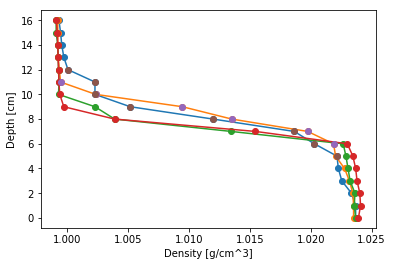

In [295]:
dAfter = [52., 52., 51.4, 50., 49.5, 49.3, 46., 43., 30.4, 16., 9., 9., 3., 2., 1.5, 1.2, .8]

denAfter = np.array(dAfter)
den29 = np.array(densities29)
den29_2 = np.array(densities29_2)
plt.plot(cond_dens(denAfter), np.arange(0, 17, 1), 'o-')
plt.plot(cond_dens(den), np.arange(0, 17, 1), 'o-')
plt.plot(cond_dens(den29), np.arange(0, 17, 1), 'o-')
plt.plot(cond_dens(den29_2), np.arange(0, 17, 1), 'o-')

plt.plot(cond_dens(den)[6:12], np.arange(6, 12, 1), 'o')
plt.plot(cond_dens(denAfter)[5:13], np.arange(5, 13, 1), 'o')
plt.xlabel('Density [g/cm^3]')
plt.ylabel('Depth [cm]')
print("05.02: ", cond_dens(denAfter)[5:13])
print("04.30: ", cond_dens(den)[6:12])

In [9]:
np.sqrt(np.abs((cond_dens(den)[8]-cond_dens(den)[7]))*980.)/(2*np.pi)

0.39313048383518284

In [230]:
drhoFirst = (cond_dens(den)[6]-cond_dens(den)[12])*1000
rho1First = cond_dens(den)[12]*1000

drhoSecond = (cond_dens(denAfter)[5]-cond_dens(den)[13])*1000
rho1Second = cond_dens(denAfter)[13]*1000
def ResonanceFrequency(d, drho, rho1):
    g = 9.81
    h1 = 0.08
    h2 = 0.08
    gdperPi = g*d/np.pi 
    rho2 = rho1 + drho
    denom = rho1/np.tanh(np.pi*h1/d) + rho2/np.tanh(np.pi*h2/d)
    rhs = np.sqrt(gdperPi*drho/denom)
    return rhs/(2*d)
TheorResonanceFirst = ResonanceFrequency(0.255, drhoFirst, rho1First)
TheorResonanceSecond = ResonanceFrequency(0.255, drhoFirst, rho1First)


def markXaxis(ax, Xpos):
    xmin, xmax = ax.get_xlim()
    xfrac = Xpos / (xmax-xmin)
    ax.annotate('', xy = (xfrac, 0), xytext=(xfrac, -0.1), xycoords = 'axes fraction', arrowprops=dict(facecolor='crimson', shrink=0.05))

In [231]:
k = 2*np.pi/2.25
def TwolayerC(k, drho, rho1):
    g = 9.81
    h1 = 0.08
    h2 = 0.08
    gdperk = g/k 
    rho2 = rho1 + drho
    denom = rho1/np.tanh(h1*k) + rho2/np.tanh(h2*k)
    rhs = np.sqrt(gdperk*drho/denom)
    return rhs

In [232]:
theor = TwolayerC(k, drhoFirst, rho1First)/(2*0.255)

In [235]:
2*theor
2*TheorResonanceFirst

0.320978058049964

In [68]:
voltage = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1., 1.1, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]

In [81]:
filt = np.logical_and(frozenFreqs<0.3, frozenFreqs>0.23)


In [82]:
print(np.array(voltage)[filt])

[1.2  1.25 1.3  1.35]


1.15 V
1.17 V
1.35 V
1.30 V
1.26 V
1.24 V
1.25 V
1.26 V
1.23 V

--- new camera angle!!

1.21 V 14:04
1.22 V 14:09
1.21 V 14:18
1.20 V 14:22
1.19 V 14:32
1.18 V 14:38
1.28 V 14:45
1.29 V 14:52
1.31 V 15:03
1.32 V 15:14

rámpák: 
15:31 - 1/3sec 
15:38 - -1/3sec

15:43 - 1/4sec 
15:49 - -1/4sec

15:57 - 1/7 sec
16:05 - -1/7 sec

--- new camera angle, eredeti driving cucc
18:10 - 1/2sec rámpa
18:15 illetve 18:22 - -1/2sec rámpa
18:24 - 1/1sec rámpa
18:27 - -1/1sec rámpa
18:31 - 2/3sec rámpa
18:34 - -2/3sec rámpa

18:39 - 1/3sec rámpa
18:45 - -1/3sec rámpa 

18:49 -1/5sec rámpa
19:00 - -1/5sec rámpa


19:07 - 1.26 V
19:09 - 1.28 V
19:11 - 1.23 v
19:13 - 1.32 V
19:15 - 1.2 V
19:16 - 1.35 V



In [294]:
densities29 = [52.0, 51.8, 51.9, 51.2, 50.9, 50.6, 50.2, 33.3, 13., 9., 0.7, 0.8, 0.7, 0.6, 0.5, 0.1, 0.1]
densities29_2 = [52.4, 52.7, 52.6, 52.2, 52.0, 51.6, 50.8, 37.1, 13., 2., 1., 0.8, 0.7, 0.6, 0.5, 0.4, 0.1]

In [189]:
def bouyantFrq(drho, rho0):
    deriv = drho
    return np.sqrt(np.abs((9.81*drho/0.01)/rho0))

array([0.        , 0.23652024, 0.52856667])

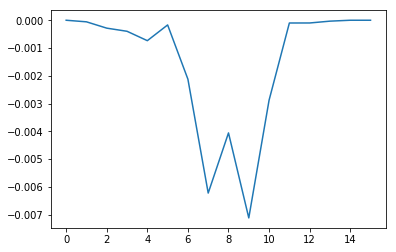

In [190]:
plt.plot(dr)
bouyantFrq(dr[0:3]*1000, 1000.)

In [177]:
h3 = 0.06
h1 = 0.06
h2 = 0.06

In [178]:
k = 2.*np.pi/2.25

In [179]:
dr = np.diff(cond_dens(den))
drho3 = np.min(dr)*1000.

In [248]:
def K_i(x, N):
    return np.sqrt(np.array(N**2/x**2 - k**2))

In [254]:
T1 = k/np.tanh(h1*k)
T3 = k/np.tanh(h2*k)

In [219]:
def T_i(x, h, N):
    return K_i(x, N)/np.tan(K_i(x, N)*h)

In [285]:
def lhs(x):
    N2 = bouyantFrq(drho3, 1000.)
    return K_i(x, N2)**2 - T1*T_i(x, h2, N2) + T1*T3 -T3*T_i(x, h2, N2) 

In [286]:
from scipy import optimize

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


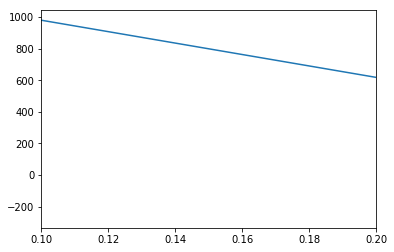

In [289]:
x = np.linspace(0.1, 100.,300)
plt.plot(x, lhs(x))
plt.xlim(0.1, 0.2)
root = optimize.newton(lhs, 0.18)

In [290]:
root

0.2020633480179237

In [291]:
res = root/(2*0.255)

In [292]:
print(res)

0.3962026431723994


In [191]:
bouyantFrq(drho3, 1000.)

2.643112267737547

In [148]:
K_i(0.00081, bouyantFrq(drho3, 1000))**2- 3.*T_i(0.00081,0.06, 0.)**2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


nan